# Fast Minimum Norm (FMN) Attack (standalone-example)

In [1]:
import logging
import foolbox as fb
import numpy as np
import torch
from foolbox import TargetedMisclassification, Misclassification
from pretrained.demo_model import MNISTModel

from src.attacks.fmn import L0FMNAttack, L1FMNAttack, \
    L2FMNAttack, LInfFMNAttack
from src.utils.data import create_loaders
from src.utils.show_digit import show_image

After the initial imports, we now take care of some setup.

In [2]:
%%capture
logger = logging.getLogger('progress')
logger.setLevel(logging.INFO)

data_dir = '../data'
norms = {'L0': 0, 'L1': 1, 'L2': 2, 'Linf': np.inf}
attacks = {'L0': L0FMNAttack, 'L1': L1FMNAttack,
           'L2': L2FMNAttack, 'Linf': LInfFMNAttack}

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

Now we can load a **model**.

In [3]:
model_name = 'mnist_convnet'
task = 'MNIST'
num_classes = {'MNIST': 10, 'CIFAR10': 10}[task]

conv_net = MNISTModel()
weights_path = "../pretrained/mnist_pretrained.pt"
state_dict = torch.load(weights_path, map_location=device)
conv_net.load_state_dict(state_dict)
conv_net.eval()

preprocessing = {'mean': 0.5,
                 'std': 0.5}

fb_model = fb.models.PyTorchModel(conv_net, bounds=(0, 1),
                                preprocessing=preprocessing,
                                device=device)

We now prepare the dataset to be used, according to the model.

In [4]:
num_batches = 1
batch_size = 20
n_workers = 1
data_loader = create_loaders(data_dir, task_config=task,
                             batch_size=batch_size,
                             transform=None,
                             random_state=0,
                             n_workers=n_workers)

We can compute the accuracy of the model, just to confirm that it is working
properly.

In [5]:
# compute clean accuracy
total, correct = 0.0, 0.0
for b, (inputs, labels) in enumerate(data_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    pred = fb_model(inputs).argmax(1)
    total += labels.shape[0]
    correct += (pred == labels).sum()
    if total >= 1000:
        break
print("Model name: {}".format(model_name))
print("Clean accuracy: {:.4f}".format(correct / total))


Model name: mnist_convnet
Clean accuracy: 0.9950


And finally, we can define the attack. We are now running the attack
with the simplest configuration. Set the `targeted` parameter to `True` or
`False` to run respectively a targeted or an untargeted attack. The targeted
version will automatically select the target labels.

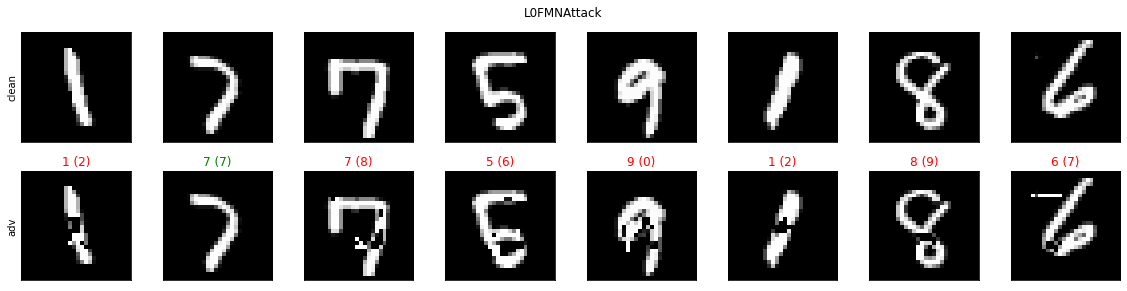

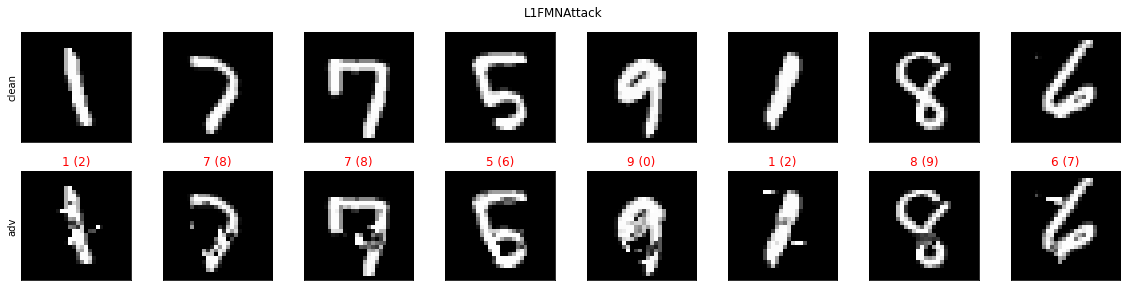

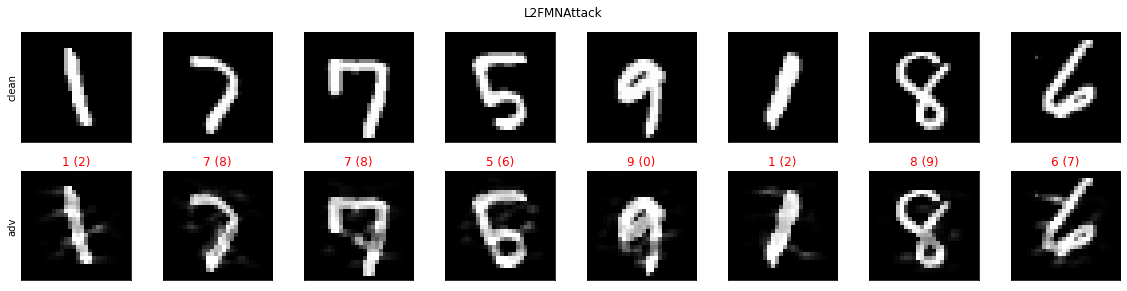

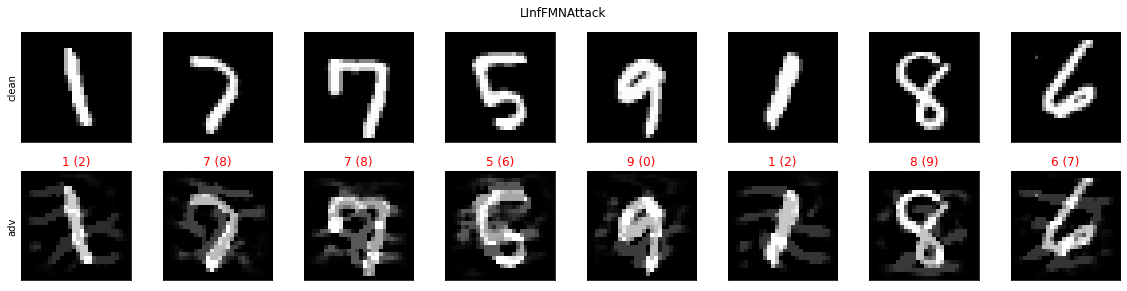

In [6]:
targeted = True
logger.info(f"attack target: {targeted}")
steps = 50
init_params = dict(steps=steps,
                   max_stepsize=1.0,
                   gamma=0.05)

for metric in norms:

    attack_class = attacks[metric]
    attack = attack_class(**init_params)

    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)


    if targeted:
        target_classes = (labels + 1) % 10
        criterion = TargetedMisclassification(target_classes)
    else:
        criterion = Misclassification(labels)
    advs, _, is_adv = attack(fb_model, images, criterion, epsilons=None)

    preds = fb_model(advs).argmax(-1)
    title = attack.__class__.__name__
    show_image(title, images, advs, preds, labels, n_display=8)
